### Улучшение baseline-модели

Этапы проекта:

- Этап 1 - Подготовка среды MLflow - shell скрипт и регистрация базовой модели.

- Этап 2 - Исследовательский Анализ Данных (EDA).

- Этап 3 - Генерация Признаков и Обучение Модели.

- Этап 4 - Отбор Признаков и Обучение Модели.

- Этап 5 - Подбор Гиперпараметров и Обучение Финальной Версии Модели.


Данные в таблице real_estate_clean:
- id — ID квартиры,
- building_id — ID дома, в котором находится квартира,
- build_year — год постройки,
- building_type_int — тип здания,
- latitude — широта, на которой находится дом,
- longitude — долгота, на которой находится дом,
- ceiling_height — высота потолков в здании,
- flats_count — общее количество квартир,
- floors_total — общее количество этажей,
- has_elevator — наличие лифта,
- floor — этаж, на котором находится квартира,
- kitchen_area — площадь кухни,
- living_area — площадь гостиной,
- rooms — количество комнат,
- is_apartment — является ли квартира апартаментами,
- studio — является ли квартира студией,
- total_area — общая площадь квартиры,
- target — цена квартиры.

In [ ]:
import seaborn as sns
import json
import matplotlib.pyplot as plt
import mlflow
import numpy as np
import optuna
import os
import pandas as pd
import psycopg
import psycopg2 as psycopg
import folium

from autofeat import AutoFeatRegressor
from catboost import CatBoostRegressor
from category_encoders import CatBoostEncoder
from geopy.distance import great_circle
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
from mlxtend.plotting import plot_sequential_feature_selection as plot_sfs
from sklearn.compose import ColumnTransformer
from sklearn.metrics import root_mean_squared_error
from sklearn.model_selection import StratifiedKFold, train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.cluster import KMeans

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', 100)

np.random.seed(42)


#### Этап 1: Регистрация базовой модели

In [2]:
# Пути и названия файлов заданы в виде параметров
PATH_DATA = '../data'

DATA_FILE = 'initial_data.csv'
DATA_FILE_X_TRAIN = 'x_train.csv'
DATA_FILE_Y_TRAIN = 'y_train.csv'
DATA_FILE_X_TEST = 'x_test.csv'
DATA_FILE_Y_TEST = 'y_test.csv'

PATH_MODELS = '../models'
MODEL_FILE = 'base_model.pkl'

RESULTS_DIR = '../results'
RESULTS_FILE = 'cv_res.json'
RESULTS_FILE_TEST = 'test_res.json'

ASSETS_DIR = '../asserts'

In [3]:
TABLE_NAME = 'real_estate_clean'

TRACKING_SERVER_HOST = "127.0.0.1"
TRACKING_SERVER_PORT = 5000

EXPERIMENT_NAME = 'real_estate_project_#2'
RUN_NAME = 'base_model'
REGISTRY_MODEL_NAME = "real_estate_model_base"

RANDOM_STATE = 42

In [3]:
# Загрузка данных
connection = {"sslmode": "require", "target_session_attrs": "read-write"}
postgres_credentials = {
    "host": os.getenv("DB_DESTINATION_HOST"),
    "port": os.getenv("DB_DESTINATION_PORT"),
    "dbname": os.getenv("DB_DESTINATION_NAME"),
    "user": os.getenv("DB_DESTINATION_USER"),
    "password": os.getenv("DB_DESTINATION_PASSWORD"),
}
assert all([var_value != "" for var_value in list(postgres_credentials.values())])

connection.update(postgres_credentials)

with psycopg.connect(**connection) as conn:

# создаёт объект курсора для выполнения запросов к базе данных
# с помощью метода execute() выполняется SQL-запрос для выборки данных из таблицы TABLE_NAME
    with conn.cursor() as cur:
        cur.execute(f"SELECT * FROM {TABLE_NAME}")
                
        # извлекаем все строки, полученные в результате выполнения запроса
        data = cur.fetchall()

        # получает список имён столбцов из объекта курсора
        columns = [col[0] for col in cur.description]


df = pd.DataFrame(data, columns=columns) 

In [4]:
# Исходные данные
df.head(2)

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,target
0,0,6220,1965,6,55.717113,37.781120,2.64,84,12,true,9,false,9.9,19.9,1,false,35.099998,9500000
1,1,18012,2001,2,55.794849,37.608013,3.00,97,10,true,7,false,0.0,16.6,1,false,43.000000,13500000


Данные будем делить на тренировочный и тестовый набор. Предполагается использовать кросс-валидацию, для получения лучшей обобщающей способности модели.

In [5]:
# Разделим датасет на тейн и тест
X = df.drop('target', axis=1)
y = df['target']

X_train, X_test, y_train, y_test = train_test_split(
        X, y, shuffle=True, test_size=0.25, random_state=RANDOM_STATE)

print(f'Размер тренировочного набора: {X_train.shape}, {y_train.shape}')
print(f'Размер тестового набора: {X_test.shape}, {y_test.shape}')

Размер тренировочного набора: (77619, 17), (77619,)
Размер тестового набора: (25874, 17), (25874,)


Поскольку я не знаю, как грузить модели из разных окружений вирутальной машины, обучим ее заново со старыми параметрами.

In [13]:
# Трансформируем данные
cat_features = X_train.select_dtypes(include='object')
# Выберем бинарные признаки
potential_binary_features = cat_features.nunique() == 2

binary_cat_features = cat_features[potential_binary_features[potential_binary_features].index]
other_cat_features = cat_features[potential_binary_features[~potential_binary_features].index]
num_features = X_train.select_dtypes(['float', 'int'])

preprocessor = ColumnTransformer(
        [
    ('binary', OneHotEncoder(drop='if_binary'), binary_cat_features.columns.tolist()),
    ('cat', CatBoostEncoder(return_df=False), other_cat_features.columns.tolist()),
    ('num', StandardScaler(), num_features.columns.tolist())
        ],
    remainder='drop',
    verbose_feature_names_out=False
    )

model_base = CatBoostRegressor(n_estimators=1000,
                              random_seed=42,
                              verbose=False,
                              loss_function='RMSE')

pipeline = Pipeline(
        [
        ('preprocessor', preprocessor),
        ('model', model_base)
        ]
    )
pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('binary',
                                                  OneHotEncoder(drop='if_binary'),
                                                  ['has_elevator',
                                                   'is_apartment']),
                                                 ('cat',
                                                  CatBoostEncoder(return_df=False),
                                                  ['building_type_int',
                                                   'studio']),
                                                 ('num', StandardScaler(),
                                                  ['id', 'building_id',
                                                   'build_year', 'latitude',
                                                   'longitude',
                                                   'ceiling_height',
                                                   'flats_count',
                                                   'floors_total', 'floor',
                                                   'kitchen_area',
                                                   'living_area', 'rooms',
                                                   'total_area'])],
                                   verbose_feature_names_out=False)),
                ('model',
                 <catboost.core.CatBoostRegressor object at 0x7fa5217099c0>)])

In [17]:
y_pred = pipeline.predict(X_test)
res_test = root_mean_squared_error(y_test, y_pred)
print(f'Результат на тестовой выборке, RMSE: {round(res_test, 3)}')

Результат на тестовой выборке, RMSE: 2166110.324


In [22]:
# Получим результат при обучении с кросс-валидацией
cv_strategy = StratifiedKFold(n_splits=3)
cv_res = cross_validate(
        pipeline,
        X_train,
        y_train,
        cv=cv_strategy,
        n_jobs=-1,
        scoring='neg_root_mean_squared_error'
        )
for key, value in cv_res.items():
        cv_res[key] = round(value.mean(), 3)

print(f'Результат при кросс-валидации, RMSE: {abs(cv_res[key])}')

Результат при кросс-валидации, RMSE: 2199017.785


In [46]:
model_base.get_params()

{'loss_function': 'RMSE',
 'random_seed': 42,
 'verbose': False,
 'n_estimators': 1000}

In [32]:
# Сохраним результат теста
with open(f'{RESULTS_DIR}/{RESULTS_FILE_TEST}', 'w') as f:
    json.dump(res_test, f)

In [34]:
# Сохраним результат кросс-валидации
with open(f'{RESULTS_DIR}/{RESULTS_FILE}', 'w') as f:
    json.dump(cv_res, f)

In [36]:
# Сохраним разделенные датасеты
X_train.to_csv(f'{PATH_DATA}/{DATA_FILE_X_TRAIN}', index=None)
y_train.to_csv(f'{PATH_DATA}/{DATA_FILE_Y_TRAIN}', index=None)
X_test.to_csv(f'{PATH_DATA}/{DATA_FILE_X_TEST}', index=None)
y_test.to_csv(f'{PATH_DATA}/{DATA_FILE_Y_TEST}', index=None)

# Сохраним исходный датасет
df.to_csv(f'{PATH_DATA}/{DATA_FILE}', index=None)

Далее залогируем исходные данные, модель и метрики.

In [65]:
cb_params = {'model__loss_function': 'RMSE',
             'model__random_seed': 42,
             'model__verbose': False,
             'model__n_estimators': 1000}

res_test = {'RMSE_test': res_test}

In [68]:
os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")


mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

# настройки для логирования в MLFlow
pip_requirements = '../requirements.txt'
signature = mlflow.models.infer_signature(X_test, y_pred)
input_example = X_test[:10]

# В первый раз создадим эксперимент
#experiment_id = mlflow.create_experiment(EXPERIMENT_NAME)
experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME).experiment_id

with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id) as run:
    run_id = run.info.run_id
    
    mlflow.log_metrics(cv_res)
    mlflow.log_metrics(res_test)
    mlflow.log_params(cb_params)

    model_info = mlflow.sklearn.log_model( 
        sk_model=pipeline,
        artifact_path="models",
        registered_model_name=REGISTRY_MODEL_NAME,
        signature=signature,
        input_example=input_example,
        await_registration_for=60,
        pip_requirements=pip_requirements)

Registered model 'real_estate_model_base' already exists. Creating a new version of this model...
2024/10/29 19:58:52 INFO mlflow.tracking._model_registry.client: Waiting up to 60 seconds for model version to finish creation. Model name: real_estate_model_base, version 1
Created version '1' of model 'real_estate_model_base'.


In [ ]:
# run_id с сохраненными артефактами базовой модели
run_id_base = '1fd53fed6e9e463a8ce9b45e2a668890'

#### Этап 2: Исследовательский Анализ Данных (EDA)

План этапа:
- Понимание данных: Первоначально ознакомьтесь с данными, изучите типы данных, проверьте наличие пропущенных значений.
- Визуализация данных: Используйте графики и диаграммы для визуализации распределений признаков и возможных взаимосвязей между ними.
- Статистический анализ: Примените статистические методы для изучения центральных тенденций, разброса и корреляций между признаками.
- Предварительные выводы: На основе проведённого анализа сформулируйте предварительные выводы о данных, которые помогут в дальнейшем этапе моделирования.


In [4]:
# Загрузка данных
df = pd.read_csv('../data/initial_data.csv', index_col=False)

In [6]:
# Общий обзор датасета
df.head(3)

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,has_elevator,floor,is_apartment,kitchen_area,living_area,rooms,studio,total_area,target
0,0,6220,1965,6,55.717113,37.781120,2.64,84,12,True,9,False,9.9,19.9,1,False,35.099998,9500000
1,1,18012,2001,2,55.794849,37.608013,3.00,97,10,True,7,False,0.0,16.6,1,False,43.000000,13500000
2,2,17821,2000,4,55.740040,37.761742,2.70,80,10,True,9,False,9.0,32.0,2,False,56.000000,13500000


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 103493 non-null  int64  
 1   building_id        103493 non-null  int64  
 2   build_year         103493 non-null  int64  
 3   building_type_int  103493 non-null  int64  
 4   latitude           103493 non-null  float64
 5   longitude          103493 non-null  float64
 6   ceiling_height     103493 non-null  float64
 7   flats_count        103493 non-null  int64  
 8   floors_total       103493 non-null  int64  
 9   has_elevator       103493 non-null  bool   
 10  floor              103493 non-null  int64  
 11  is_apartment       103493 non-null  bool   
 12  kitchen_area       103493 non-null  float64
 13  living_area        103493 non-null  float64
 14  rooms              103493 non-null  int64  
 15  studio             103493 non-null  bool   
 16  to

In [17]:
df.describe()

,id,building_id,build_year,building_type_int,latitude,longitude,ceiling_height,flats_count,floors_total,floor,kitchen_area,living_area,rooms,total_area,target
count,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,103493.000000,1.034930e+05
mean,68546.243253,13171.463191,1984.141314,3.523630,55.728188,37.604233,2.687509,223.001701,13.020649,6.726039,8.101251,27.533055,1.945552,51.592527,1.179991e+07
std,41104.240116,6438.634112,19.376710,1.415885,0.103325,0.148727,0.130793,133.797179,5.122506,4.508221,2.986849,14.425440,0.815831,16.222243,4.510034e+06
min,0.000000,173.000000,1912.000000,0.000000,55.427238,37.190800,2.450000,1.000000,1.000000,1.000000,0.000000,0.000000,1.000000,11.000000,1.100000e+01
25%,32623.000000,8161.000000,1969.000000,4.000000,55.648724,37.496128,2.640000,111.000000,9.000000,3.000000,6.000000,19.000000,1.000000,38.400002,8.500000e+06
50%,67293.000000,12819.000000,1979.000000,4.000000,55.717560,37.591682,2.640000,192.000000,12.000000,6.000000,8.400000,28.400000,2.000000,48.000000,1.080000e+07
75%,103651.000000,18529.000000,2002.000000,4.000000,55.813778,37.722462,2.700000,300.000000,17.000000,9.000000,10.000000,36.000000,3.000000,60.400002,1.400000e+07
max,141361.000000,24620.000000,2023.000000,6.000000,56.011032,37.946411,3.000000,640.000000,29.000000,20.000000,16.300000,74.000000,5.000000,120.300003,2.872000e+07


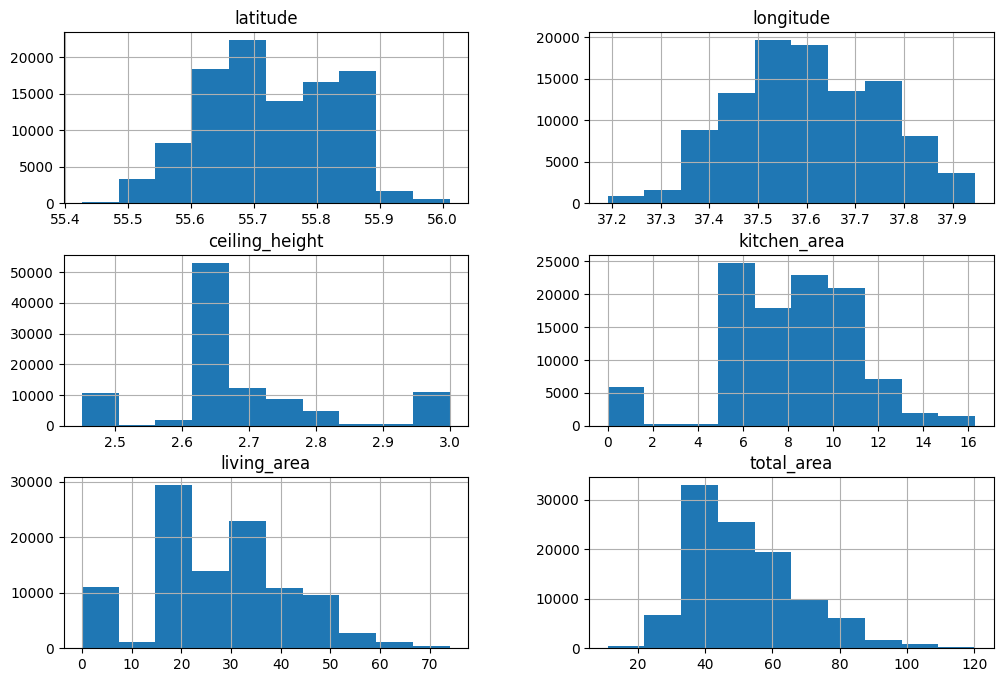

In [47]:
# Анализ признаков для модели
df.select_dtypes('float').hist(figsize=(12,8));

plt.savefig(os.path.join(ASSETS_DIR, 'int_float_features_distribution'))

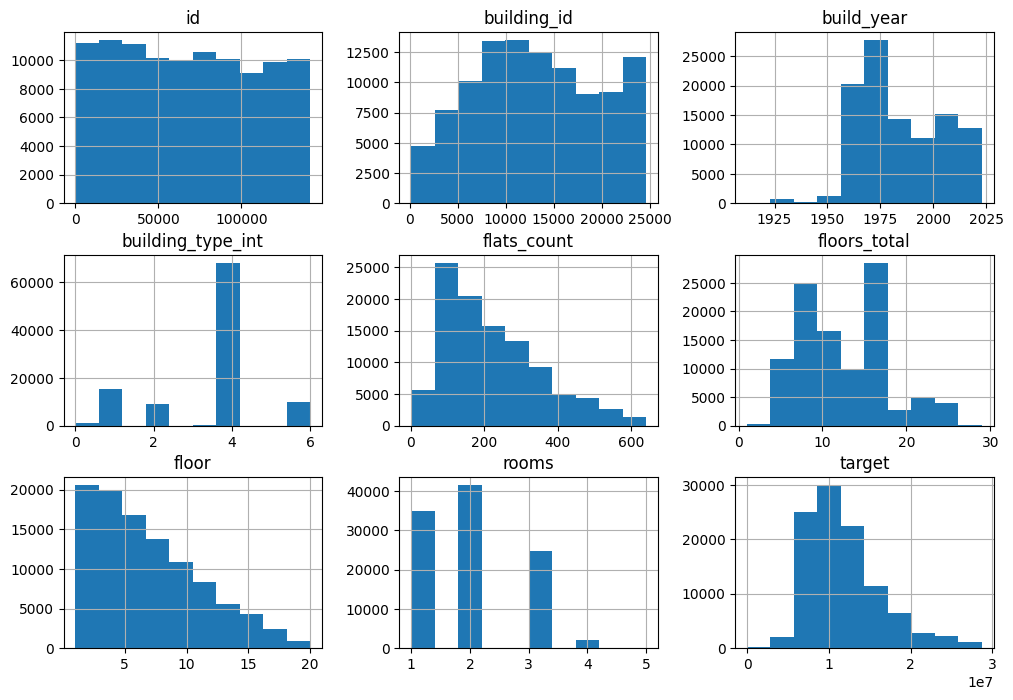

In [46]:
df.select_dtypes('int').hist(figsize=(12,8));

plt.savefig(os.path.join(ASSETS_DIR, 'int_hist_features_distribution'))

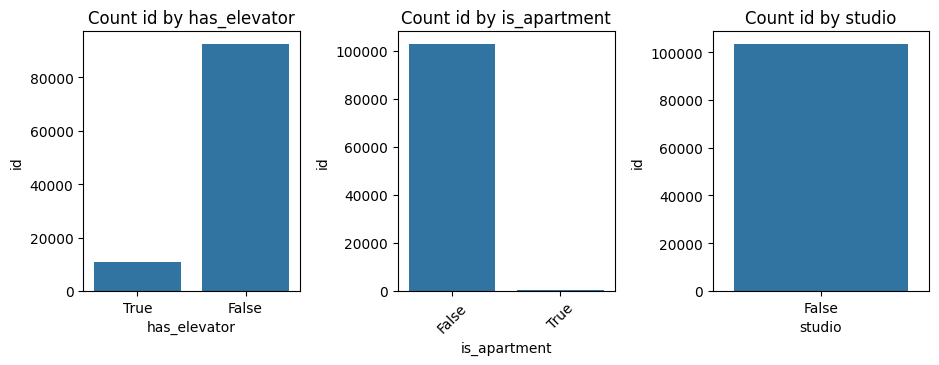

In [45]:
fig, axs = plt.subplots(1, 3)
fig.set_size_inches(10, 4, forward=True)
fig.tight_layout(pad=4)


x = "has_elevator"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[0])
axs[0].set_title(f'Count {y} by {x}')
axs[0].set_xticklabels(df[x].unique(), rotation = 0);

x = "is_apartment"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[1])
axs[1].set_title(f'Count {y} by {x}')
axs[1].set_xticklabels(df[x].unique(), rotation = 45);

x = "studio"
y = "id"
stat = ["count"]
agg_df = df.groupby(x).agg({y: 'count'}).reset_index()
sns.barplot(agg_df, x=x, y=y, ax=axs[2])
axs[2].set_title(f'Count {y} by {x}')
axs[2].set_xticklabels(df[x].unique(), rotation = 0);


plt.savefig(os.path.join(ASSETS_DIR, 'bool_features_in_initial_dataframe'))

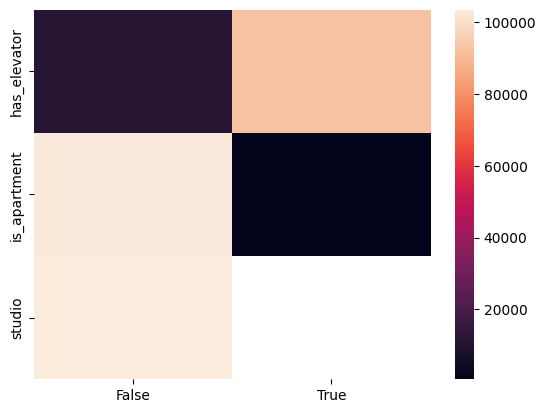

In [63]:
x = "id"
binary_columns = [
    "has_elevator", 
    "is_apartment", 
    "studio"
]

heat_df = df[binary_columns].apply(pd.Series.value_counts).T
sns.heatmap(heat_df)

plt.savefig(os.path.join(ASSETS_DIR, 'bool_features_heatmap'))

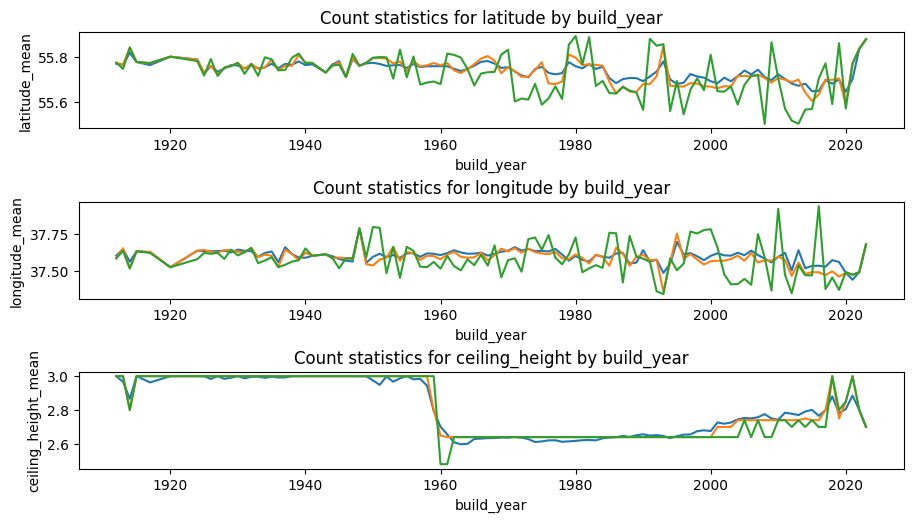

In [ ]:
# инициализация переменной для названия колонки
x = "build_year"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
    "latitude",
    "longitude",
    'ceiling_height'
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик 
latitude_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
latitude_agg.columns = latitude_agg.columns.droplevel()
# переименование колонок для удобства восприятия
latitude_agg.columns = [x, "latitude_mean", "latitude_median", "latitude_mode"]

longitude_agg = df[[x] + [charges_columns[1]]].dropna().groupby([x]).agg(stats).reset_index()
longitude_agg.columns = longitude_agg.columns.droplevel()
longitude_agg.columns = [x, "longitude_mean", "longitude_median", "longitude_mode"]

ceiling_height_agg = df[[x] + [charges_columns[2]]].dropna().groupby([x]).agg(stats).reset_index()
ceiling_height_agg.columns = ceiling_height_agg.columns.droplevel()
ceiling_height_agg.columns = [x, "ceiling_height_mean", "ceiling_height_median", "ceiling_height_mode"]

# создание объекта для отображения графиков
fig, axs = plt.subplots(3, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(10, 5.5, forward=True)

# построение линейных графиков для ежемесячных платежей
sns.lineplot(latitude_agg, ax=axs[0], x=x, y='latitude_mean')
sns.lineplot(latitude_agg, ax=axs[0], x=x, y="latitude_median")
sns.lineplot(latitude_agg, ax=axs[0], x=x, y="latitude_mode")
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

sns.lineplot(longitude_agg, ax=axs[1], x=x, y='longitude_mean')
sns.lineplot(longitude_agg, ax=axs[1],  x=x, y="longitude_median")
sns.lineplot(longitude_agg, ax=axs[1],  x=x, y="longitude_mode")

axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

sns.lineplot(ceiling_height_agg, ax=axs[2], x=x, y='ceiling_height_mean')
sns.lineplot(ceiling_height_agg, ax=axs[2],  x=x, y="ceiling_height_median")
sns.lineplot(ceiling_height_agg, ax=axs[2],  x=x, y="ceiling_height_mode")

axs[2].set_title(f"Count statistics for {charges_columns[2]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_float_1_by_year'))

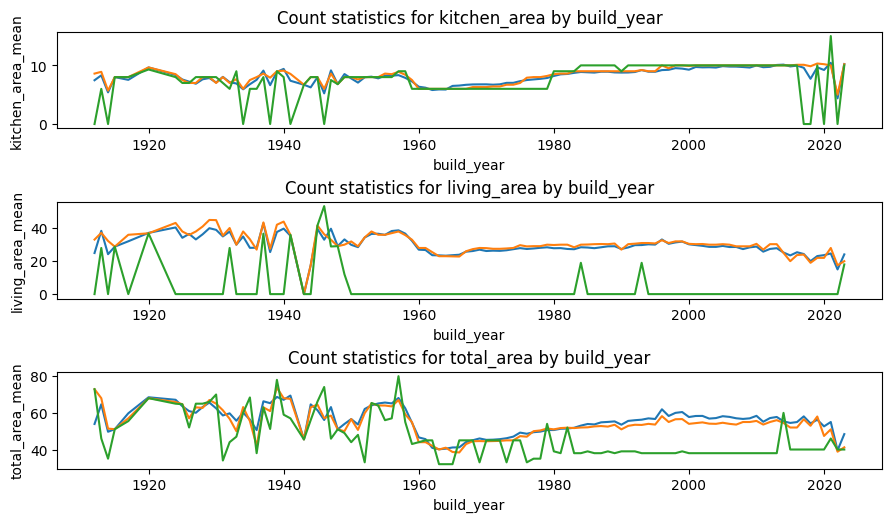

In [ ]:
# инициализация переменной для названия колонки
x = "build_year"

# список колонок, для которых будут вычисляться статистики
charges_columns = [
     'kitchen_area','living_area','total_area'
]

# удаление пустых колонок для посчёта медианного значения
df[charges_columns].dropna(inplace=True)

# список статистик, которые будут вычисляться для каждой группы
stats = ["mean", "median", lambda x: x.mode().iloc[0]]  # среднее значение, медиана и мода

# группировка данных по дате начала и агрегация статистик 
kitchen_area_agg = df[[x] + [charges_columns[0]]].groupby([x]).agg(stats).reset_index()
# удаление верхнего уровня индекса колонок (после агрегации)
kitchen_area_agg.columns = kitchen_area_agg.columns.droplevel()
# переименование колонок для удобства восприятия
kitchen_area_agg.columns = [x, "kitchen_area_mean", "kitchen_area_median", "kitchen_area_mode"]

living_area_agg = df[[x] + [charges_columns[1]]].dropna().groupby([x]).agg(stats).reset_index()
living_area_agg.columns = living_area_agg.columns.droplevel()
living_area_agg.columns = [x, "living_area_mean", "living_area_median", "living_area_mode"]

total_area_agg = df[[x] + [charges_columns[2]]].dropna().groupby([x]).agg(stats).reset_index()
total_area_agg.columns = total_area_agg.columns.droplevel()
total_area_agg.columns = [x, "total_area_mean", "total_area_median", "total_area_mode"]

# создание объекта для отображения графиков
fig, axs = plt.subplots(3, 1)
# настройка отступов между графиками
fig.tight_layout(pad=2.5)
# установка размера фигуры
fig.set_size_inches(10, 5.5, forward=True)

# построение линейных графиков 
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y='kitchen_area_mean')
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y="kitchen_area_median")
sns.lineplot(kitchen_area_agg, ax=axs[0], x=x, y="kitchen_area_mode")
# установка заголовка для верхнего графика
axs[0].set_title(f"Count statistics for {charges_columns[0]} by {x}")

sns.lineplot(living_area_agg, ax=axs[1], x=x, y='living_area_mean')
sns.lineplot(living_area_agg, ax=axs[1],  x=x, y="living_area_median")
sns.lineplot(living_area_agg, ax=axs[1],  x=x, y="living_area_mode")
# установка заголовка для нижнего графика
axs[1].set_title(f"Count statistics for {charges_columns[1]} by {x}")

sns.lineplot(total_area_agg, ax=axs[2], x=x, y='total_area_mean')
sns.lineplot(total_area_agg, ax=axs[2],  x=x, y="total_area_median")
sns.lineplot(total_area_agg, ax=axs[2],  x=x, y="total_area_mode")
# установка заголовка для нижнего графика
axs[2].set_title(f"Count statistics for {charges_columns[2]} by {x}")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'charges_float_2_by_year'))

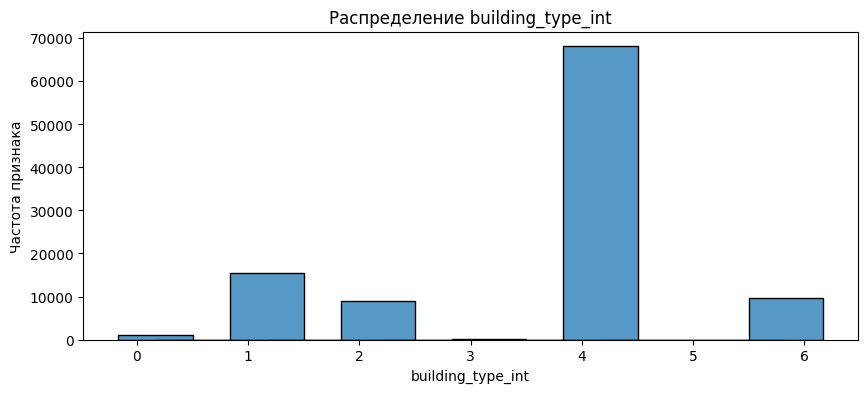

In [45]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='building_type_int',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('building_type_int')
plt.ylabel('Частота признака')
plt.title('Распределение building_type_int');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'building_type_int_distribution'))

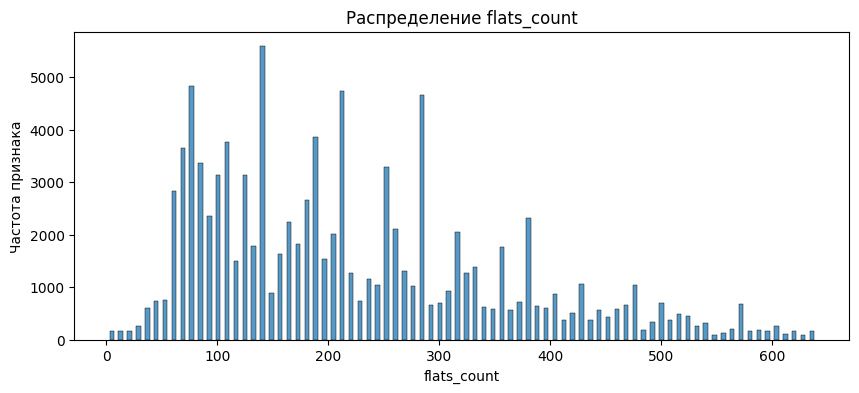

In [46]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='flats_count',  
             multiple='dodge', 
             shrink=0.5)

plt.xlabel('flats_count')
plt.ylabel('Частота признака')
plt.title('Распределение flats_count');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'flats_count_distribution'))

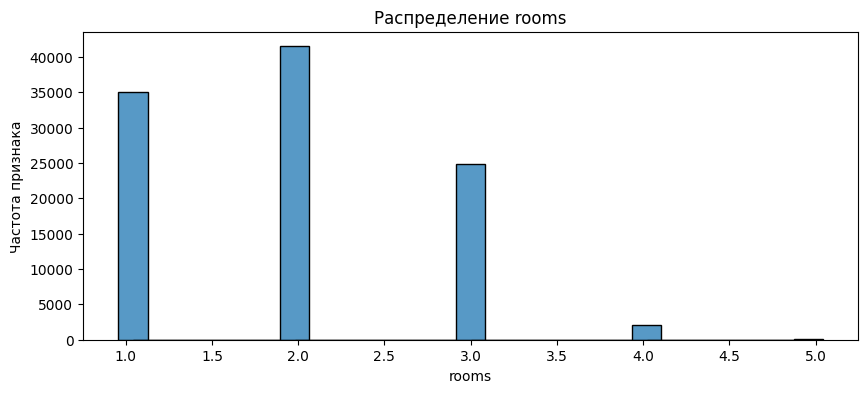

In [47]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='rooms',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('rooms')
plt.ylabel('Частота признака')
plt.title('Распределение rooms');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'rooms_distribution'))

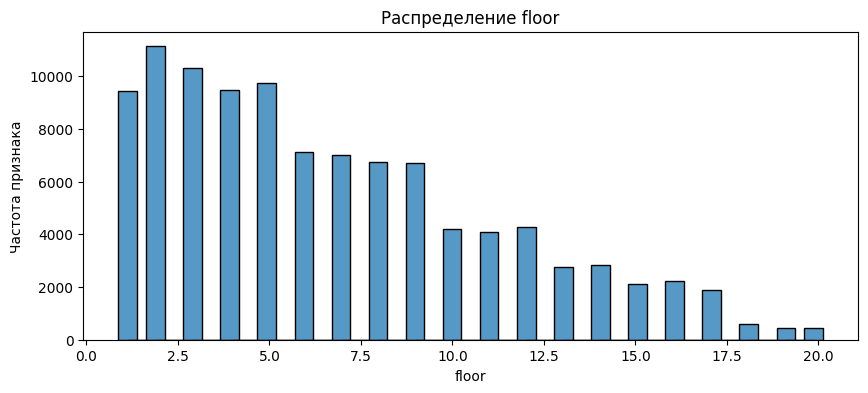

In [48]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='floor',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('floor')
plt.ylabel('Частота признака')
plt.title('Распределение floor');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'floor_distribution'))

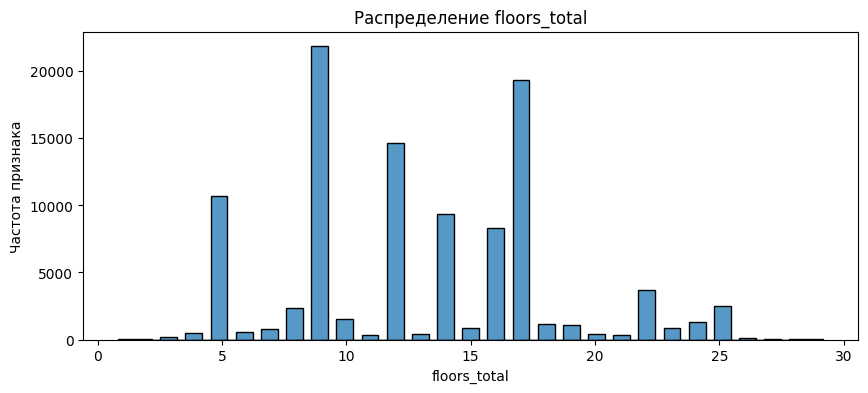

In [49]:
#зададим размер диаграммы
plt.figure(figsize=(10,4))

#зададим параметры диаграммы
sns.histplot(data=df, 
             x='floors_total',  
             multiple='dodge', 
             shrink=2)

plt.xlabel('floors_total')
plt.ylabel('Частота признака')
plt.title('Распределение floors_total');

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'floors_total_distribution'))

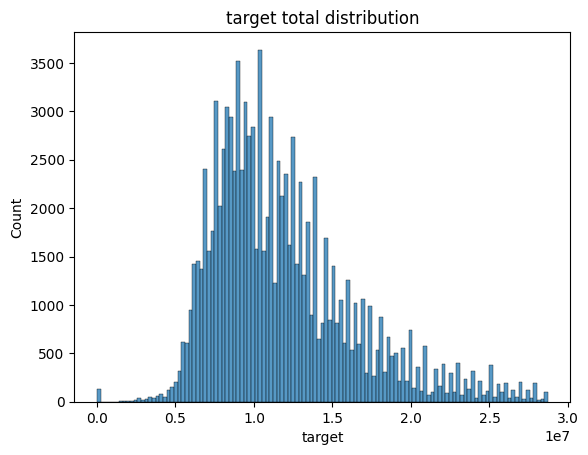

In [88]:
# Анализ целевой переменной

# установка названия колонки для агрегации
x = "target"

# создание столбчатой диаграммы для визуализации распределения целевой переменной
sns.histplot(df[x])

# установка заголовка графика
plt.title(f"{x} total distribution")

# сохранение графика в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_count'))

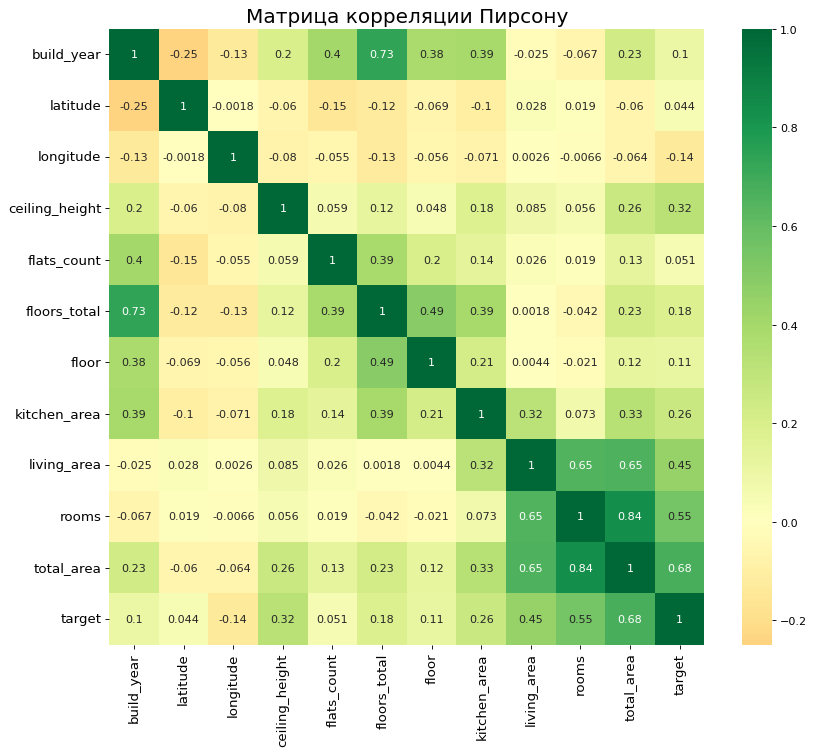

<Figure size 640x480 with 0 Axes>

In [25]:
#посмотрим на корреляцию численных признаков друг на друга и на целевой показатель
columns_to_show = ['build_year',
                   'latitude',
                   'longitude',
                   'ceiling_height',
                   'flats_count',
                   'floors_total',
                   'floor',
                   'kitchen_area',
                   'living_area',
                   'rooms',
                   'total_area',
                   'target']

plt.figure(figsize=(12,10), dpi= 80)
sns.heatmap(df[columns_to_show].corr(), xticklabels=df[columns_to_show].corr().columns, 
            yticklabels=df[columns_to_show].corr().columns, 
            cmap='RdYlGn', center=0, annot=True)

#выведем результат
plt.title('Матрица корреляции Пирсону', fontsize=18)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.show()

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'feature_correlation'))

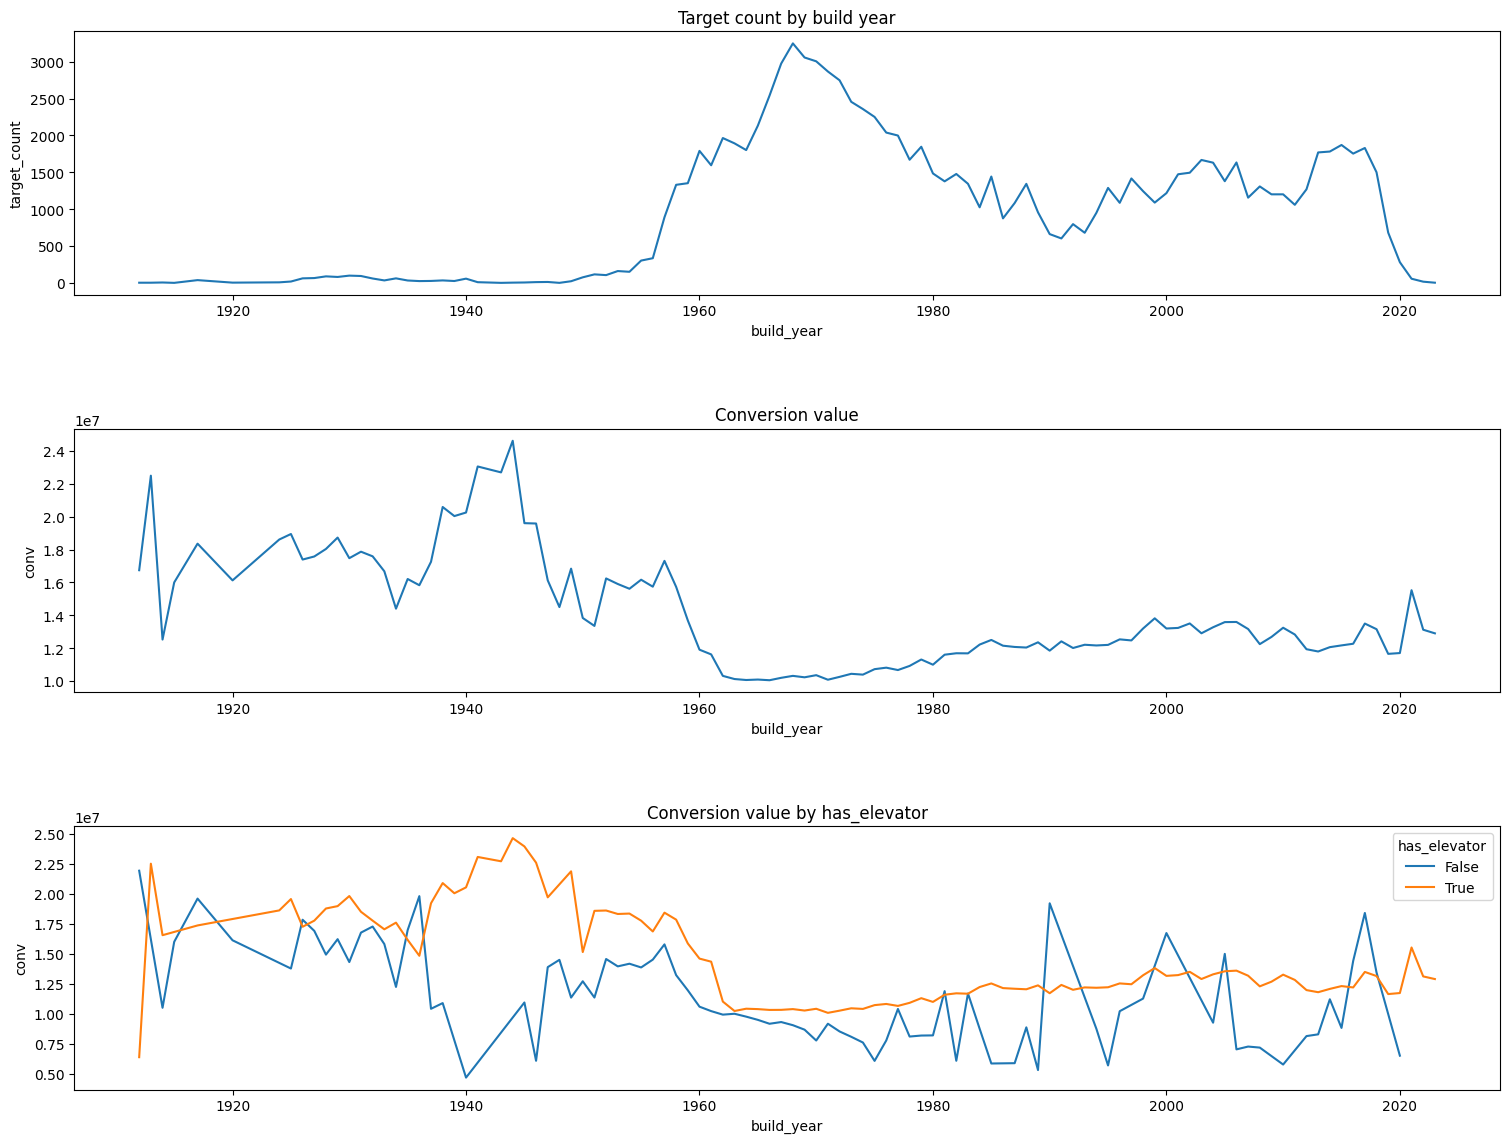

In [7]:
# 2.4 Анализ целевой переменной в зависимости от различных признаков
# установка переменных для анализа
x = "build_year"
target = "target"

# определение статистики для агрегации
stat = ["count"]

# агрегация количества целей по датам начала с последующим сбросом индекса
target_agg_by_date = df[[x, target]].groupby([x]).agg(stat).reset_index()
# удаление мультиуровневости заголовков после агрегации и переименование для удобства
target_agg_by_date.columns = target_agg_by_date.columns.droplevel()
target_agg_by_date.columns = [x, "target_count"]

# подсчёт количества клиентов для каждого значения цели по датам
target_agg = df[[x, target, 'id']].groupby([x, target]).count().reset_index()

# расчёт суммы и количества для конверсии по датам
conversion_agg = df[[x, target]].groupby([x])['target'].agg(['sum', 'count']).reset_index()
# вычисление коэффициента конверсии и округление до двух знаков
conversion_agg['conv'] = (conversion_agg['sum'] / conversion_agg['count']).round(2)

# аналогичный расчет конверсии, но с дополнительным разделением по полу
conversion_agg_elevator = df[[x, target, 'has_elevator']].groupby([x, 'has_elevator'])[target].agg(['sum', 'count']).reset_index()
conversion_agg_elevator['conv'] = (conversion_agg_elevator['sum'] / conversion_agg_elevator['count']).round(2)

# инициализация фигуры для отображения нескольких графиков
fig, axs = plt.subplots(3, 1)
fig.tight_layout(pad=1.6)  # настройка отступов между подграфиками
fig.set_size_inches(16.5, 12.5, forward=True)  # установка размера фигуры

# визуализация общего количества целей по датам начала
sns.lineplot(data=target_agg_by_date, x=x, y='target_count', ax=axs[0])
axs[0].set_title("Target count by build year")


# визуализация коэффициента конверсии по датам
sns.lineplot(data=conversion_agg, x=x, y="conv", ax=axs[1])
axs[1].set_title("Conversion value")

# визуализация коэффициента конверсии по датам с разделением по полу
sns.lineplot(data=conversion_agg_elevator, x=x, y='conv', hue='has_elevator', ax=axs[2])
axs[2].set_title("Conversion value by has_elevator")

# сохранение визуализации в файл
plt.savefig(os.path.join(ASSETS_DIR, 'target_by_date'))

Text(0.5, 1.0, 'building_type_int distribution')

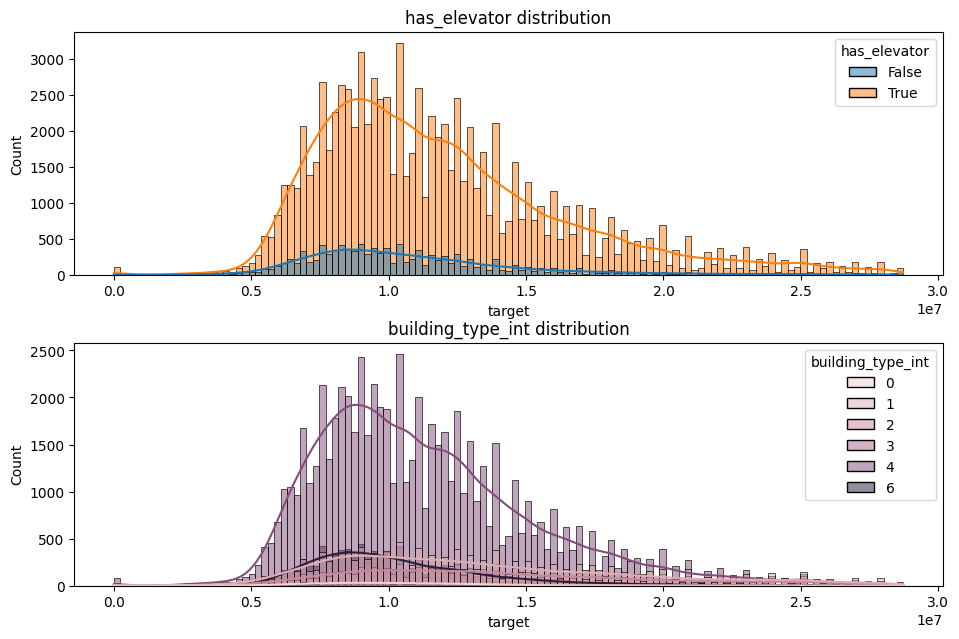

In [ ]:
# определение списка столбцов с данными о платежах и целевой переменной
charges = ["has_elevator", "building_type_int"]
target = "target"

# инициализация фигуры для отображения гистограмм
fig, axs = plt.subplots(2, 1)
fig.tight_layout(pad=1.5)  # настройка отступов между подграфиками
fig.set_size_inches(10, 6.5, forward=True)  # установка размера фигуры

# визуализация распределения целевой переменной с разделением по наличию лифта
sns.histplot(data=df, x=target, hue=charges[0], kde=True, ax=axs[0])
# указание, на каком подграфике отобразить гистограмму
axs[0].set_title(f"{charges[0]} distribution")  

# визуализация распределения целевой переменной с разделением по типу строения
sns.histplot(data=df, x=target, hue=charges[1], kde=True, ax=axs[1])
# указание, на каком подграфике отобразить вторую гистограмму
axs[1].set_title(f"{charges[1]} distribution")  

# сохранение фигуры с гистограммами в файл
plt.savefig(os.path.join(ASSETS_DIR, 'chargest_by_target_dist'))

Далее изучим геоданные

In [45]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 21 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   id                    103493 non-null  int64  
 1   building_id           103493 non-null  int64  
 2   build_year            103493 non-null  int64  
 3   building_type_int     103493 non-null  int64  
 4   latitude              103493 non-null  float64
 5   longitude             103493 non-null  float64
 6   ceiling_height        103493 non-null  float64
 7   flats_count           103493 non-null  int64  
 8   floors_total          103493 non-null  int64  
 9   has_elevator          103493 non-null  bool   
 10  floor                 103493 non-null  int64  
 11  is_apartment          103493 non-null  bool   
 12  kitchen_area          103493 non-null  float64
 13  living_area           103493 non-null  float64
 14  rooms                 103493 non-null  int64  
 15  

In [ ]:
# За середину возьмем локацию Москвы
m = folium.Map(location=[55.7522, 37.6156], zoom_start=6)

# Добавим точки на карту
for lat, lon in zip(df['latitude'], df['longitude']):
    folium.CircleMarker(location=[lat, lon], radius=5, color='blue').add_to(m)

Поскольку карта занимает имеет большой размер, поэтому сохраним локацию в виде картинки только в ячейке

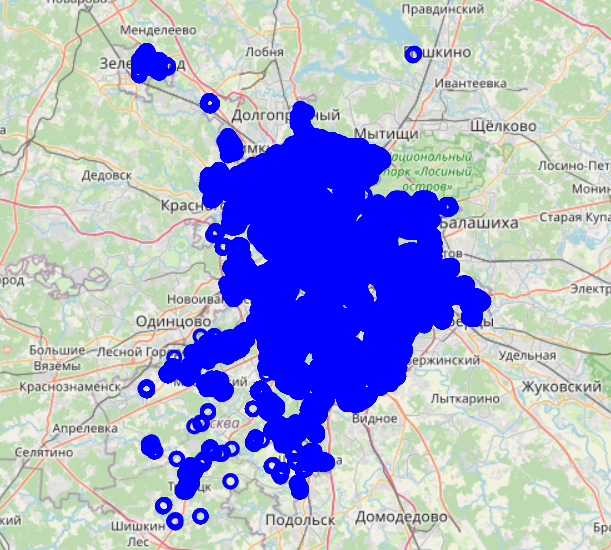

#### Выводы после EDA


1. Признаки is_apartment и studio бесполезны. В первом признаке сильный дисбаланс, а в studio одно значение.
2. Цена жилья растет с увеличением площади и этажности.
3. Цена на жилье четко делится в цене по году постройки, старый фонд (до 1960 года) имеет более высокую цену.
4. Сам целевой признак имеет нормальное распределение.
5. Наиболее широко представ слелующий тип жилья:
    - без лифта;
    - тип 4;
    - 5, 9 и 17 этажные строения;
    - квартиры находятся до 5 этажа;
    - квартиры с 2 комнатами;
    - жилая площадь до 40 кв. метров;
    - высота потолков 2,6 м, в старом фонде 3 м.

Данные относятся к инфморации и продажах в Москве и области. Чтобы дополнительно учесть локацию, можно предположить, что определенный тип построек характер для определенных районов, а также этажность и год построки. Дополнительно добавим признаки, которые можно извлеч из геоданных.

In [31]:
# 2.6 логирование артефактов в MLflow

RUN_NAME = 'feature_statistics'

os.environ["MLFLOW_S3_ENDPOINT_URL"] = "https://storage.yandexcloud.net" 
os.environ["AWS_ACCESS_KEY_ID"] = os.getenv("AWS_ACCESS_KEY_ID") 
os.environ["AWS_SECRET_ACCESS_KEY"] = os.getenv("AWS_SECRET_ACCESS_KEY")

mlflow.set_tracking_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")
mlflow.set_registry_uri(f"http://{TRACKING_SERVER_HOST}:{TRACKING_SERVER_PORT}")

experiment_id = mlflow.get_experiment_by_name(EXPERIMENT_NAME)


with mlflow.start_run(run_name=RUN_NAME, experiment_id=experiment_id.experiment_id) as run:
    run_id = run.info.run_id

    mlflow.log_artifacts(ASSETS_DIR) 

In [32]:
# сохраним run_id
run_id

'8fa4c380add342a6858f4732c7449e21'

#### Этап 3: Генерация Признаков и Обучение Новой Версии Модели

Шаги этапа:

- Определение и генерация новых признаков на основе гипотез.
- Использование библиотек для автоматической генерации признаков.
- Интеграция новых признаков в  модель с помощью Pipeline или ColumnTransformer для ручно созданных признаков.
- Обучение новой версии модели с использованием всех доступных признаков.
- Логирование результатов в MLflow для документирования и анализа эффективности новых признаков и модели.


In [42]:
# 3.1 ручная генерация признаков

# Добавим столбец с категорией жилого фонда по году постройки
def build_year(df):
    year_build=df['build_year']
    if year_build <=1960:
        return 'old_1900'
    elif year_build > 1960 and year_build <= 1990:
        return 'medium_1990'
    elif year_build > 1990 and year_build <= 2000:
        return 'medium_2000'
    else:
        return 'new'
    
df['build_type_by_year'] = df.apply(lambda x: build_year(x), axis=1)

df['build_type_by_year'].value_counts()

build_type_by_year
medium_1990    57500
new            28012
medium_2000    10370
old_1900        7611
Name: count, dtype: int64

In [41]:
# Добавим столбец с категорией жилого фонда по этажности
def floor_build(df):
    floor_build=df['floors_total']
    if floor_build == 5:
        return '5_level'
    elif floor_build == 9:
        return '9_level'
    elif floor_build == 17:
        return '17_level'
    else:
        return 'other_level'
    
df['build_type_by_floors'] = df.apply(lambda x: floor_build(x), axis=1)

df['build_type_by_floors'].value_counts()

build_type_by_floors
other_level    51601
9_level        21852
17_level       19354
5_level        10686
Name: count, dtype: int64

In [43]:
# Добавим признак первого и последнего этажа
def floor(df):
    floor=df['floor']
    floors_total = df['floors_total']
    if floor ==1:
        return 'first_level'
    elif floor == floors_total:
        return 'last_level'
    else:
        return 'other_level'
    
df['floor_type'] = df.apply(lambda x: floor(x), axis=1)

df['floor_type'].value_counts()

floor_type
other_level    84570
last_level      9476
first_level     9447
Name: count, dtype: int64

In [ ]:
# Зададим координаты садового кольца и МКАД
central_road_noth = [55.774016, 37.619225]
central_road_south = [55.729858, 37.623123]
central_road_west = [55.754213, 37.656708]
central_road_east = [55.754213, 37.583379]

sub_road_noth = [55.911066, 37.584806]
sub_road_south = [55.572908, 37.642425]
sub_road_west = [55.761951, 37.843677]
sub_road_east = [55.749805, 37.367278]


def region(row):
    if row['latitude'] > 55.77:
        return 'noth'
    elif row['latitude'] < 55.73:
        return 'south'
    else:
        return 'central'

df['region'] = df.apply(region, axis=1)


df['region'].value_counts()

region
south      55070
noth       38948
central     9475
Name: count, dtype: int64

In [ ]:
# Разделим условно данные на 4 района
kmeans = KMeans(n_clusters=4, random_state=0).fit(df[['latitude', 'longitude']])
df['cluster_region'] = kmeans.labels_

df['cluster_region'].value_counts()

cluster_region
0    32898
1    31464
3    23071
2    16060
Name: count, dtype: int64

In [ ]:
# Зададим координаты центра города
moscow = (55.753114, 37.623681)

# Расчитаем расстояние до центра города
distance_km = great_circle(san_francisco, los_angeles).kilometers
print(f"Distance between San Francisco and Los Angeles: {distance_km:.2f} km")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 103493 entries, 0 to 103492
Data columns (total 20 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 103493 non-null  int64  
 1   building_id        103493 non-null  int64  
 2   build_year         103493 non-null  int64  
 3   building_type_int  103493 non-null  int64  
 4   latitude           103493 non-null  float64
 5   longitude          103493 non-null  float64
 6   ceiling_height     103493 non-null  float64
 7   flats_count        103493 non-null  int64  
 8   floors_total       103493 non-null  int64  
 9   has_elevator       103493 non-null  bool   
 10  floor              103493 non-null  int64  
 11  is_apartment       103493 non-null  bool   
 12  kitchen_area       103493 non-null  float64
 13  living_area        103493 non-null  float64
 14  rooms              103493 non-null  int64  
 15  studio             103493 non-null  bool   
 16  to

In [ ]:
from geopy.distance import great_circle

# Добавим расстояние до центра
moscow= (55.7522, 37.6156)

for 

# Calculate distance in kilometers
distance_km = great_circle(san_francisco, los_angeles).kilometers
print(f"Distance between San Francisco and Los Angeles: {distance_km:.2f} km")

In [ ]:
# 3.2 оборачивание всех преобразований в объекты sklearn

In [ ]:
# 3.3 автоматическая генерация признаков

In [ ]:
# 3.4 обучение новой версии модели

In [ ]:
# 3.5 логирование артефактов в MLflow

#### Этап 4: Отбор Признаков и Обучение Новой Версии Модели
Создание новых признаков — это лишь часть работы. Следующий важный шаг — это убедиться в том, что каждый из этих признаков действительно вносит положительный вклад в качество модели. Некоторые признаки могут оказывать отрицательное влияние на модель, поэтому их следует исключить из анализа.

На этом этапе, мы рекомендуем вам применить различные методы отбора признаков для того, чтобы определить и удалить те признаки, которые не улучшают качество вашей модели. Цель этого этапа — максимизировать производительность модели, удалив избыточные или неинформативные признаки.

После тщательного отбора признаков, пора обучить новую версию вашей модели, уже без негативно влияющих на неё признаков. Важно залогировать результаты этого этапа, включая измененный набор признаков, параметры модели и полученные метрики качества, в MLflow для последующего анализа и сравнения.

Рекомендуемые шаги:

- Применение методов отбора признаков для идентификации и исключения признаков, ухудшающих качество модели.
- Анализ влияния каждого признака на модель, чтобы понять, какие из них наиболее ценные.
- Обучение новой версии модели без негативно влияющих признаков.
- Логирование всех изменений и результатов в MLflow, включая конечный набор признаков, параметры модели и метрики качества.

Этот этап не только поможет улучшить качество вашей модели, но и даст глубокое понимание о важности и влиянии отдельных признаков на результаты моделирования.


In [ ]:
# 4.1 Отбор признаков при помощи метода номер 1

In [ ]:
# 4.2 Отбор признаков при помощи метода номер 2

In [ ]:
# 4.3 Анализ отобранных признаков при помощи двух методов и формирование финального списка с признаками для модели

In [ ]:
# 4.4 Обучение новой версии модели

In [ ]:
# 4.5 Логирование всех артефактов в MLflow

### Этап 5 - подбор гиперпараметров и обучение новой версии модели
После того как мы уделили значительное внимание качеству модели через создание и отбор признаков, пришло время для финального штриха — подбора гиперпараметров. Этот этап является ключевым в финальной части проекта второго спринта, где ваша задача — оптимизировать гиперпараметры модели для достижения наилучшего качества.

Рекомендуется подобрать гиперпараметры как минимум двумя различными методами (например, с использованием Grid Search и Random Search), чтобы вы могли сравнить результаты и выбрать наиболее эффективный набор гиперпараметров для вашей модели. После определения оптимальных гиперпараметров, наступает время обучить финальную версию модели, используя ваши новые признаки.

Рекомендуемые шаги:

- Выбор методов для подбора гиперпараметров: Определитесь с методами, которые вы будете использовать для подбора гиперпараметров (например, Grid Search, Random Search, Bayesian Optimization).
- Подбор гиперпараметров: Примените выбранные методы для нахождения оптимальных значений гиперпараметров вашей модели.
- Сравнение результатов: Анализируйте и сравнивайте результаты, полученные различными методами, для определения наилучшего набора гиперпараметров.
- Обучение финальной модели: Используя выбранные гиперпараметры, обучите финальную версию вашей модели на новых признаках.
- Документирование процесса и результатов: Залогируйте все шаги и результаты в MLflow, включая сравнение методов подбора гиперпараметров и характеристики финальной модели.

Этот этап позволит вам максимально улучшить качество вашей модели перед финальной оценкой, предоставив полное понимание важности и влияния гиперпараметров на производительность модели.

In [ ]:
# 5.1 Подбор гиперпарметров при мощи метода номер 1

In [ ]:
# 5.2 Подбор гиперпарметров при мощи метода номер 2

In [ ]:
# 5.3 Формирование списка гиперпараметров для новой модели

In [ ]:
# 5.4 Обуение финальной версии модели

In [ ]:
# 5.5 Логирование артефактов в MLflow